
## Basic settings and parameters

`EBTgymEnv()` class comes preconfigured for quick setting. Basicaly one need to provide at least data file keyword argument to set it up. 

BTgym relies on Backtrader framework for actual environment rendering. Environment customisation can be done either via setting basic set of parameters, inherited from Backtrader computational engine, or passing to env. complete engine  subclass. This example covers basic setting, while  later option gives complete control over backtasting logic and environment becames as flexible as Backtrader itself.
 
Besides, there is another bunch of vital options related to reinforcement learning setting: observation and action space parameters and episode setting.
 
One can eyeball internal environment parameters by looking at nested  `MyEnvironment.params` dictionary consisting of these subdictionaries:
   - `params['dataset']`,  
   - `params['engine']`,
   - `params['strategy']`,
   - `params['other']`.
 
- Look at source files for exact parameters descriptions, since complete doc. reference is yet to come.
##### Here all parameters are left to defaults values:

In [1]:
from btgym import BTgymEnv

# Simpliest trading environment,
# using year-long dataset of one minute bars for EUR/USD currency pair: 

 
MyEnvironment = BTgymEnv(filename='./data/DAT_ASCII_EURUSD_M1_2016.csv',)

# Print parameters and their default values:

for params_name, params_dict in MyEnvironment.params.items():
    print('\nParameters [{}] subset: '.format(params_name))
    for key, value in params_dict.items():
        print('{} : {}'.format(key,value))
            


Parameters [dataset] subset: 
filename : ./data/DAT_ASCII_EURUSD_M1_2016.csv
start_weekdays : [0, 1, 2]
start_00 : True
episode_len_days : 1
episode_len_hours : 23
episode_len_minutes : 55
time_gap_days : 0
time_gap_hours : 5

Parameters [engine] subset: 
start_cash : 10.0
broker_commission : 0.001
fixed_stake : 10

Parameters [strategy] subset: 
state_shape : (4, 10)
state_low : 1.03522
state_high : 1.1616
drawdown_call : 90
portfolio_actions : ('hold', 'buy', 'sell', 'close')
skip_frame : 1

Parameters [other] subset: 
port : 5500
network_address : tcp://127.0.0.1:5500
verbose : 0


*****
### More control:
##### One can tweak environment setup by passing set of kwargs:

In [255]:
MyEnvironment = BTgymEnv(filename='../examples/data/DAT_ASCII_EURUSD_M1_2016.csv',
                         
                     # Dataset and single random episode related parameters:
                         
                         # We start trading on mondays, thuesdays and wednesdays:
                         start_weekdays=[0, 1, 2],
                         # Want total episode duration to be no more than 1 day 23h 55min:
                         episode_len_days=1,
                         episode_len_hours=23,
                         episode_len_minutes=55,
                         # Want to start every episode at the begiining of the day:
                         start_00=True,
                         
                     # Broker and trade realted:
                         
                         # Set initial capital:
                         start_cash=100,
                         # Set broker commission as 0.2% of operation value:
                         broker_commission=0.002,
                         # We use fixed stake of size 10:
                         fixed_stake=10,
                         # We want stop episode if 30% of initial capital is lost:
                         drawdown_call=30,
                         
                     # RL environment related parameters:
                         
                         # Set obserbation shape. By convention, last dimension 
                         # is time embedding dimensionality;
                         # that's basically means we get sequence of 30 last  
                         # [o,h,l,c] candels as our one-step environment observation.
                         state_shape=(4,50),
                         
                         # Observations min and max. possible values.
                         # Setting these to None forces environment to infer from entire dataset.
                         # Since our obs. space by default consisits of series of prices,
                         # it's quite reasonable:
                         state_low=None,
                         state_high=None,
                         
                     # Other parameters:
                         
                         # Network port to use; note that using multiply environments at once reqires expliciltly
                         # setting differen ports to avoid meesing up. If your jupyter kernel suddenly dies
                         # when running new environment - that's may be because of port conflict,
                         # or 'previous' environment instance (client-side) is still running.
                         # Don't panic, just clear up and restart kernel.
                         port=5555,
                         # Be chatty: settting this to 1 makes environment report what's going on;
                         # 2 is for debugging, dumps out a lot of data:
                         verbose=1,)


[2017-06-24 19:01:43,782] Base Dataset class used.
[2017-06-24 19:01:43,784] Base Cerebro engine used. Base Strategy class used.
[2017-06-24 19:01:44,487] Loaded 372678 records from <../examples/data/DAT_ASCII_EURUSD_M1_2016.csv>.
[2017-06-24 19:01:44,574] Data summary:
                open           high            low          close    volume
count  372678.000000  372678.000000  372678.000000  372678.000000  372678.0
mean        1.107109       1.107198       1.107019       1.107108       0.0
std         0.024843       0.024840       0.024847       0.024844       0.0
min         1.035250       1.035470       1.035220       1.035220       0.0
25%         1.092140       1.092230       1.092040       1.092140       0.0
50%         1.113530       1.113610       1.113450       1.113530       0.0
75%         1.124710       1.124780       1.124630       1.124710       0.0
max         1.161440       1.161600       1.160770       1.161450       0.0
[2017-06-24 19:01:44,574] Flushed data.
[2017

*****
### Registering environment:

OpenaAI way of making environment is to register it with cpecific set of parameters under some unique name and instantiate it via calling  `make()` method. This helps for standartization and correct evaluation of results uploaded to Gym board. 
 
##### That's how you do it (same parameters as above):

In [3]:
import gym

# Set single dictionary of parameters:

env_params = dict(filename='../examples/data/DAT_ASCII_EURUSD_M1_2016.csv',
                  start_weekdays=[0, 1, 2],
                  episode_len_days=1,
                  episode_len_hours=23,
                  episode_len_minutes=55,
                  start_00=True,
                  start_cash=100,
                  broker_commission=0.002,
                  fixed_stake=10,
                  drawdown_call=50,
                  state_shape=(4,30),
                  state_low=None,
                  state_high=None,
                  port=5555,
                  verbose=1,)

# Register with unique name (watch out for OpenAI namesetting conventions):

gym.envs.register(id='backtrader-v46',
                  entry_point='btgym:BTgymEnv',
                  kwargs=env_params)

# Make environment:
                  
MyEnvironment = gym.make('backtrader-v46')


[2017-06-22 23:43:35,315] Making new env: backtrader-v46
[2017-06-22 23:43:35,318] Base Dataset class used.
[2017-06-22 23:43:35,319] Base Cerebro engine used. Base Strategy class used.
[2017-06-22 23:43:36,022] Loaded 372678 records from <../examples/data/DAT_ASCII_EURUSD_M1_2016.csv>.
[2017-06-22 23:43:36,107] Data summary:
                open           high            low          close    volume
count  372678.000000  372678.000000  372678.000000  372678.000000  372678.0
mean        1.107109       1.107198       1.107019       1.107108       0.0
std         0.024843       0.024840       0.024847       0.024844       0.0
min         1.035250       1.035470       1.035220       1.035220       0.0
25%         1.092140       1.092230       1.092040       1.092140       0.0
50%         1.113530       1.113610       1.113450       1.113530       0.0
75%         1.124710       1.124780       1.124630       1.124710       0.0
max         1.161440       1.161600       1.160770       1.16145

*****
### Running agent:

Just for giving sense of env. operation flow, our agent will be just mindless random picker; it performs no actual training. Run it for several episodes to see how fast all the money get lost. We'll plot states observationas as imagemaps every 500th step.

###### Note: using render() method requires matplotlib to be installed.

[2017-06-24 23:36:45,060] No running server found, starting...
[2017-06-24 23:36:45,281] Server PID: 80310
[2017-06-24 23:36:46,223] Loaded 372678 records from <../examples/data/DAT_ASCII_EURUSD_M1_2016.csv>.
[2017-06-24 23:36:46,255] Server started, pinging tcp://127.0.0.1:5555 ...
[2017-06-24 23:36:46,258] Server seems ready with response: <CONTROL_MODE, send <_reset>, <_getstat> or <_stop>.>
[2017-06-24 23:36:46,259] Starting episode.
[2017-06-24 23:36:46,263] Maximum episode time duration set to: 1 day, 23:55:00.
[2017-06-24 23:36:46,265] Respective number of steps: 2875.
[2017-06-24 23:36:46,267] Maximum allowed data time gap set to: 5:00:00.

[2017-06-24 23:36:46,271] Episode start: 2016-07-05 15:54:00, weekday: 1.
[2017-06-24 23:36:46,273] Start time adjusted to <00:00.>
[2017-06-24 23:36:46,293] Episode duration: 1 day, 23:57:00.
[2017-06-24 23:36:46,295] Total episode time gap: 0:02:00.
[2017-06-24 23:36:46,296] Sample accepted.
[2017-06-24 23:36:46,315] Data summary:
        

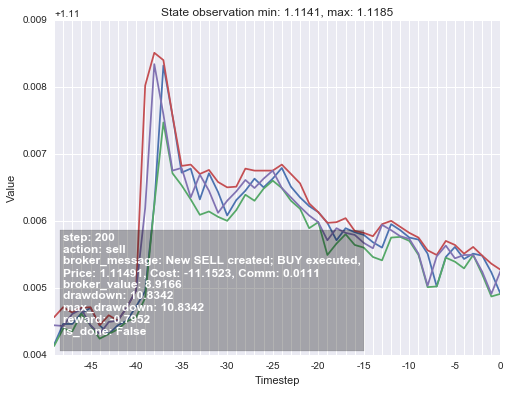

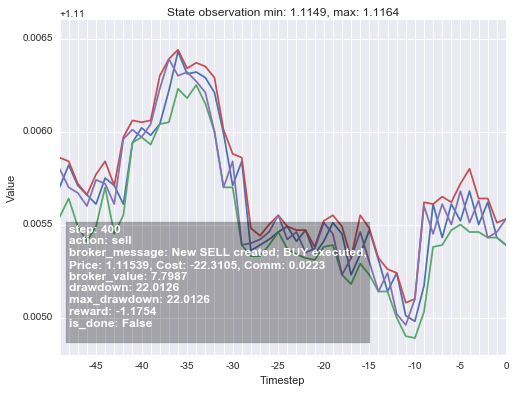

[2017-06-24 23:36:49,866] Episode elapsed time: 0:00:03.546346.


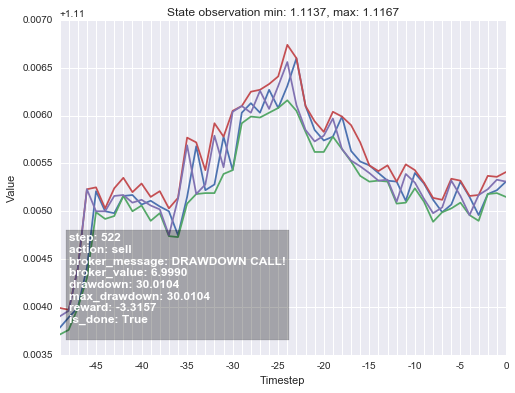

[2017-06-24 23:36:50,360] Episode statistic sent.
[2017-06-24 23:36:50,361] Starting episode.
[2017-06-24 23:36:50,363] Maximum episode time duration set to: 1 day, 23:55:00.
[2017-06-24 23:36:50,365] Respective number of steps: 2875.
[2017-06-24 23:36:50,366] Maximum allowed data time gap set to: 5:00:00.

[2017-06-24 23:36:50,368] Episode start: 2016-04-01 10:38:00, weekday: 4.
[2017-06-24 23:36:50,370] Not a good day to start, resampling...
[2017-06-24 23:36:50,371] Episode start: 2016-12-15 14:43:00, weekday: 3.
[2017-06-24 23:36:50,372] Not a good day to start, resampling...
[2017-06-24 23:36:50,374] Episode start: 2016-09-15 20:45:00, weekday: 3.
[2017-06-24 23:36:50,375] Not a good day to start, resampling...
[2017-06-24 23:36:50,377] Episode start: 2016-12-22 18:25:00, weekday: 3.
[2017-06-24 23:36:50,378] Not a good day to start, resampling...
[2017-06-24 23:36:50,380] Episode start: 2016-01-05 13:27:00, weekday: 1.
[2017-06-24 23:36:50,381] Start time adjusted to <00:00.>
[20

STAT:
episode: 1
runtime: 0:00:03.546346

INFO:
step: 522
action: sell
broker_message: DRAWDOWN CALL!
broker_value: 6.9990
drawdown: 30.0104
max_drawdown: 30.0104
reward: -3.3157
is_done: True



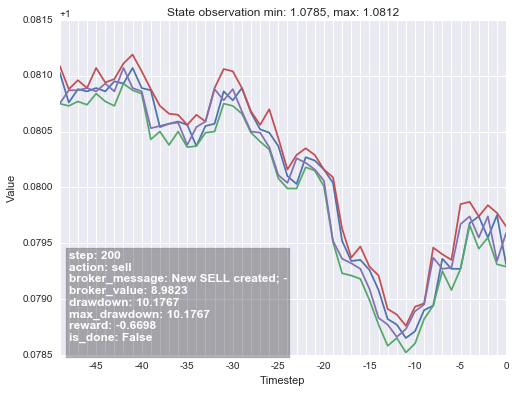

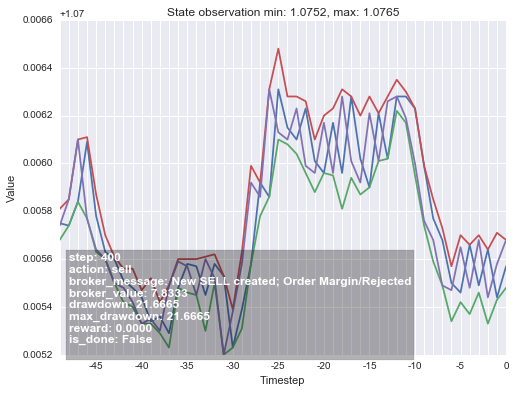

[2017-06-24 23:36:54,256] Episode elapsed time: 0:00:03.848240.


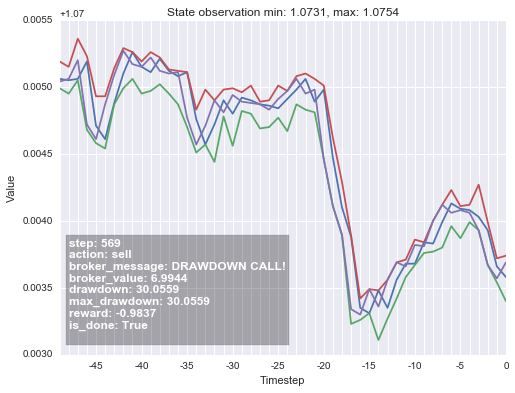

[2017-06-24 23:36:54,616] Episode statistic sent.
[2017-06-24 23:36:54,618] Starting episode.
[2017-06-24 23:36:54,620] Maximum episode time duration set to: 1 day, 23:55:00.
[2017-06-24 23:36:54,621] Respective number of steps: 2875.
[2017-06-24 23:36:54,623] Maximum allowed data time gap set to: 5:00:00.

[2017-06-24 23:36:54,626] Episode start: 2016-07-06 12:13:00, weekday: 2.
[2017-06-24 23:36:54,628] Start time adjusted to <00:00.>
[2017-06-24 23:36:54,631] Episode duration: 1 day, 23:58:00.
[2017-06-24 23:36:54,632] Total episode time gap: 0:03:00.
[2017-06-24 23:36:54,634] Sample accepted.
[2017-06-24 23:36:54,649] Data summary:
              open         high          low        close  volume
count  2875.000000  2875.000000  2875.000000  2875.000000  2875.0
mean      1.107566     1.107667     1.107464     1.107566     0.0
std       0.001570     0.001567     0.001577     0.001569     0.0
min       1.103710     1.104060     1.102900     1.103710     0.0
25%       1.106200     1.1

STAT:
episode: 2
runtime: 0:00:03.848240

INFO:
step: 569
action: sell
broker_message: DRAWDOWN CALL!
broker_value: 6.9944
drawdown: 30.0559
max_drawdown: 30.0559
reward: -0.9837
is_done: True



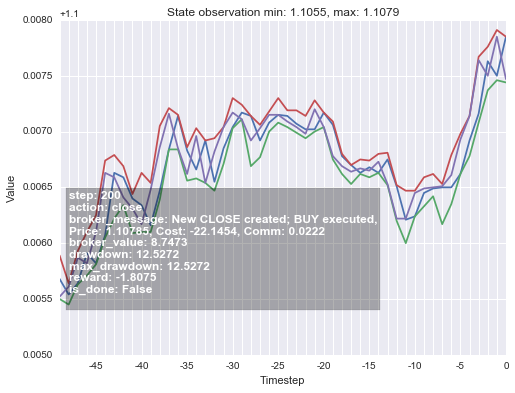

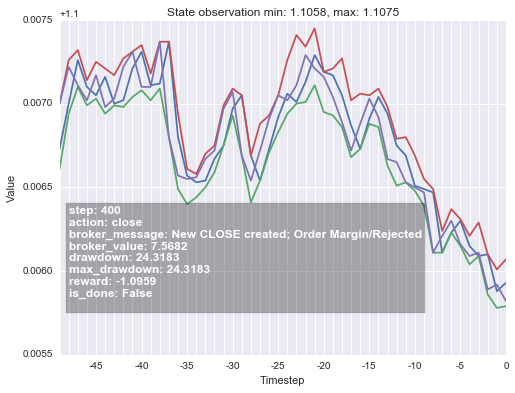

[2017-06-24 23:36:58,607] Episode elapsed time: 0:00:03.954760.


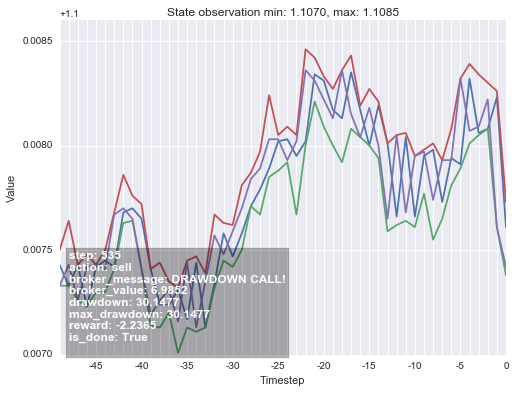

[2017-06-24 23:36:58,955] Episode statistic sent.
[2017-06-24 23:36:58,957] Starting episode.
[2017-06-24 23:36:58,959] Maximum episode time duration set to: 1 day, 23:55:00.
[2017-06-24 23:36:58,960] Respective number of steps: 2875.
[2017-06-24 23:36:58,961] Maximum allowed data time gap set to: 5:00:00.

[2017-06-24 23:36:58,964] Episode start: 2016-01-21 22:49:00, weekday: 3.
[2017-06-24 23:36:58,965] Not a good day to start, resampling...
[2017-06-24 23:36:58,966] Episode start: 2016-03-02 04:05:00, weekday: 2.
[2017-06-24 23:36:58,968] Start time adjusted to <00:00.>
[2017-06-24 23:36:58,971] Episode duration: 1 day, 23:55:00.
[2017-06-24 23:36:58,972] Total episode time gap: 0:00:00.
[2017-06-24 23:36:58,974] Sample accepted.
[2017-06-24 23:36:58,990] Data summary:
              open         high          low        close  volume
count  2875.000000  2875.000000  2875.000000  2875.000000  2875.0
mean      1.088884     1.088972     1.088796     1.088886     0.0
std       0.004077 

STAT:
episode: 3
runtime: 0:00:03.954760

INFO:
step: 535
action: sell
broker_message: DRAWDOWN CALL!
broker_value: 6.9852
drawdown: 30.1477
max_drawdown: 30.1477
reward: -2.2365
is_done: True



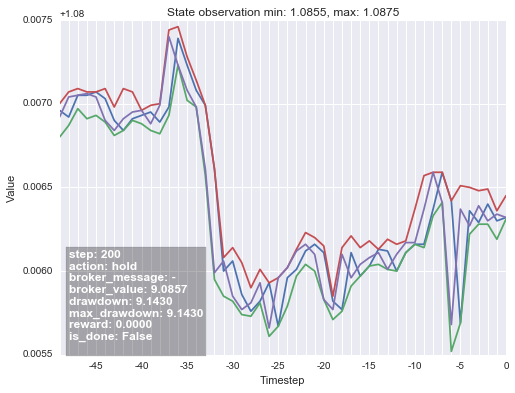

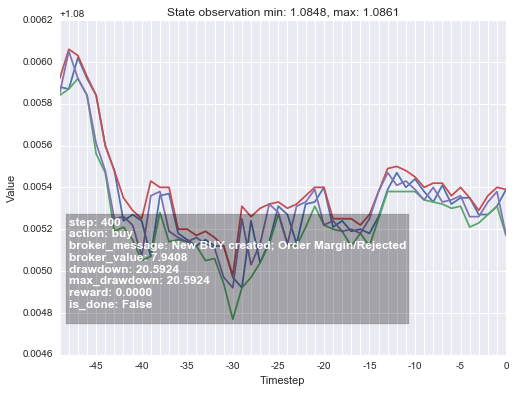

[2017-06-24 23:37:02,952] Episode elapsed time: 0:00:03.957983.


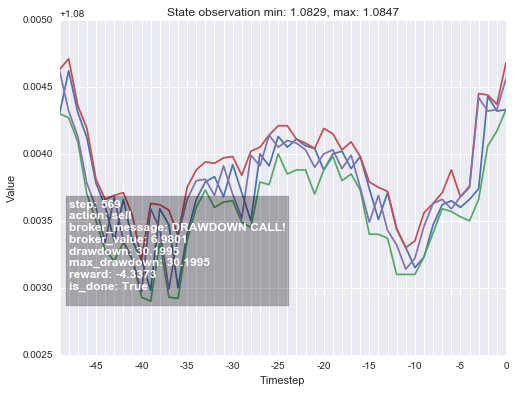

[2017-06-24 23:37:03,307] Episode statistic sent.
[2017-06-24 23:37:03,309] Server is exiting.
[2017-06-24 23:37:03,310] Server is exiting. Exit code: None


STAT:
episode: 4
runtime: 0:00:03.957983

INFO:
step: 569
action: sell
broker_message: DRAWDOWN CALL!
broker_value: 6.9801
drawdown: 30.1995
max_drawdown: 30.1995
reward: -4.3373
is_done: True



In [271]:
import itertools
import random
import numpy as np

import matplotlib 
import matplotlib.pyplot as plt
%matplotlib inline

#

def to_string(dictionary):
     """Fromat utility function"""
    text = ''
    for k, v in dictionary.items():
        if type(v) in [float]:
            v = '{:.4f}'.format(v)
        text += '{}: {}\n'.format(k, v)
    return(text)

# Number  episodes to run:
num_episodes = 4

# Render every:
state_render=200

for episode in range(num_episodes):
    
    # Calling reset() before every episode.
    # Watch for log output: when called for first time, it will start the server, 
    # than samples episode and return initial state observation (by simply making one step):
    init_state = MyEnvironment.reset()
    
    # Render first step:
    MyEnvironment.render()
    
    # Repeat until episode end:
    for _1 in itertools.count(): 
        
        #Choose random action:
        rnd_action = int((MyEnvironment.action_space.n)*random.random())
        
        # Make a step in the environment:
        obs, reward, done, info = MyEnvironment.step(rnd_action)
        
        #Plot state every 500th step
        # and when episode is finished:
        if info[-1]['step'] % state_render == 0 or done:
            
            MyEnvironment.render()
                
        if done: break
            
    # Print episode statistic (quite useless for now since we didn't added any observers etc.)
    print('STAT:\n{}\nINFO:\n{}'.format(to_string(MyEnvironment.get_stat()),
                                        to_string(info[-1])))

# Clean up:
MyEnvironment.close()


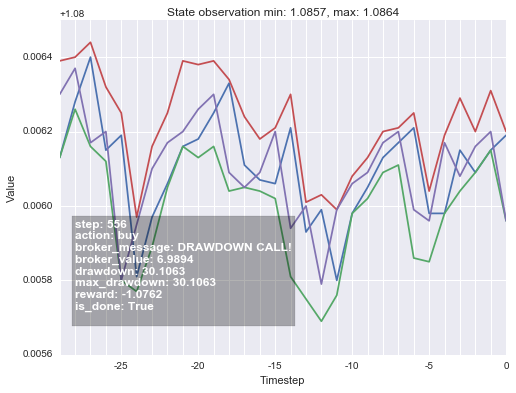

In [250]:
#from numpy import linspace

info_dict = info[-1]
info_dict.update(reward=reward, is_done=done)

plt.figure(figsize=(8, 6))
plt.style.use('seaborn')
plt.title(
    'State observation min: {:.4f}, max: {:.4f}'.
      format(obs.min(), obs.max())
)
# Plot x axis as reversed time-step embedding:
xticks = linspace(obs.shape[-1]-1, 0, int(obs.shape[-1]), dtype=int)
plt.xticks(xticks.tolist(), (- xticks[::-1]).tolist(), visible=False)

# Set every 5th tick label visible:
for tick in plt.xticks()[1][::5]:
    tick.set_visible(True)

plt.xlabel('Timestep')
plt.ylabel('Value')
plt.grid(True)

plt.plot(obs.T)

# Add Info block:
plt.text(
    1, obs.T.min(),
    to_string(info[-1]),
    fontsize=12, fontweight='bold', color='w',
    bbox={'facecolor':'k', 'alpha':0.3, 'pad':3},
)
plt.show()